# Author IOU computation 
## Oct 12, 2022

In [2]:
import pandas as pd
from pathlib import Path
import sys 
import gc
from tqdm.auto import tqdm 
import re
from string import punctuation
import matplotlib.pyplot as plt 
import seaborn as sns
import igraph as ig 
import ast
import orjson as json
import datetime as dt
import pyarrow.parquet as pq
import plotly.express as px
import plotly.io as pio

tqdm.pandas()
plt.rcParams.update({'font.size': 22})
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

pd.options.plotting.backend = 'plotly'
pio.templates.default = 'plotly_dark+presentation'

In [3]:
basepath = Path('/N/project/openalex/ssikdar/filtered')

For the whole dataset, run this cell

In [301]:
years = [2017, 2018, 2019, 2020, 2021, 2022]

dataset = pq.ParquetDataset(basepath / 'works_authorship_split', use_legacy_dataset=False,
                            filters=[('year', 'in', years),])

works_authors_df = dataset.read().to_pandas()

display(f'{len(works_authors_df)=:,}')
display(works_authors_df.head())

'len(works_authors_df)=137,068,709'

,work_id,author_id,author_name,institution_id,publication_date,year,month
3389,2286263278,3175442675,Jeffrey Brown,<NA>,2017-01-01,2017,1
3422,2286418227,2630270478,Nicole Coutrelis,<NA>,2017-01-01,2017,1
3423,2286418227,2342147013,Thomas Gourdea,<NA>,2017-01-01,2017,1
6467,2295757329,2157057934,Margaret Hodgins,<NA>,2017-01-01,2017,1
6468,2295757329,2778590059,Paul Fleming,<NA>,2017-01-01,2017,1


For the small snapshot, run the following cell instead

In [4]:
works_authors_df = pd.read_parquet('../data/works_authors_small.parquet')
works_authors_df

,work_id,author_id,author_name,institution_id,publication_date
4066359,2597768936,2113839928,Carlo Ratti,<NA>,2017-01-01
4066360,2597768936,2303729449,Anthony Townsend,<NA>,2017-01-01
7810095,2564771753,2570477082,Alexander Kocian,108290504,2017-01-03
7810096,2564771753,1979704246,Mihai-Alin Badiu,891191580,2017-01-03
7810097,2564771753,2472223787,Bernard Henri Fleury,891191580,2017-01-03
...,...,...,...,...,...
27521817,4224234379,4221802513,Xiaohu Zhang,68236693,2022-06-01
27521818,4224234379,4224574267,Martina Mazzarello,63966007,2022-06-01
27521819,4224234379,2980553576,Lin Yang,14243506,2022-06-01
27521820,4224234379,2980553576,Lin Yang,14243506,2022-06-01


In [32]:
def jaccard(list_of_lists):    
    list_of_sets = [set(l) for l in list_of_lists]
    intersection = set.intersection(*list_of_sets)
    union = set.union(*list_of_sets)

    return len(intersection) / max(1, len(union))

def rolling_iou_author(author_id, works_authors, window_size=2):
    """
    author_id: author id for the intended author
    works_authors: dataframe linking works and authors - must have publication_date 
    window_size: window parameter for the pd.rolling method 
    """
    # get all rows for the author, and set the publication date as the index 
    authors_works_df = (
        works_authors
        .query('author_id==@author_id', engine='python')
        .drop_duplicates(subset=['work_id'])  # drop works with multiple affils 
        .sort_values(by='publication_date')
        .set_index('publication_date')
    )
    
    # get the work ids for the author
    author_work_ids = set(
        authors_works_df
        .work_id
        .unique()
    )
    
    # store the set of coauthors for each work id sorted by date 
    temporal_coauthors_df = authors_works_df.join(
        works_authors
        .query('work_id.isin(@author_work_ids)', engine='python')
        .groupby('work_id')
        .author_id
        .apply(lambda ser: set(ser) - {author_id})  # remove the author from the set 
        .rename('coauthors'),
        on='work_id'
    )

    res = (
        temporal_coauthors_df
        .assign(
            rolling_coauthors=lambda df_: ([window.to_list()
                                            for window in 
                                            df_
                                            .coauthors
                                            .rolling(window=window_size)]),   # possible bug here
            window_size=window_size
        )
        .assign(rolling_jaccard=lambda df_: df_.rolling_coauthors.apply(jaccard))  # calculate jaccard
    )
    
    return res

In [12]:
# carlo, santo, paolo, and Tim's IDs 
author_ids = [2122189410, 2113839928, 2127131468, 2037649753]
combined_df = None

In [29]:
rolling_iou_author(author_id=author_ids[0], works_authors=works_authors_df, window_size=2).head()

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,window_size,rolling_jaccard
publication_date,,,,,,,,
2017-04-01,2604374094,2122189410,Santo Fortunato,<NA>,"{2156931689, 2105367364, 2037037628, 2074066684}","[{2156931689, 2105367364, 2037037628, 20740666...",2,1.000000
2017-07-01,2766966917,2122189410,Santo Fortunato,<NA>,"{2949512033, 2395754243, 3210888771, 223870407...","[{2156931689, 2105367364, 2037037628, 20740666...",2,0.000000
2017-10-06,2761435952,2122189410,Santo Fortunato,<NA>,"{1274808907, 2257442005}","[{2949512033, 2395754243, 3210888771, 22387040...",2,0.076923
2018-02-15,3121329986,2122189410,Santo Fortunato,<NA>,"{2157809153, 2952575497, 2025463562, 216398695...","[{1274808907, 2257442005}, {2157809153, 295257...",2,0.010000
2018-02-19,2963041679,2122189410,Santo Fortunato,592451,"{1274808907, 2257442005}","[{2157809153, 2952575497, 2025463562, 21639869...",2,0.010000


In [26]:
rolling_window_size = 5  # for the number of papers in each window
# rolling_window_size = '365D'  # for a time period 

if combined_df is None:  # empty dataframe 
    # append all the rows for each author
    combined_df = (
        pd.concat([rolling_iou_author(author_id=aid, works_authors=works_authors_df, 
                                      window_size=rolling_window_size)  
                   for aid in tqdm(author_ids)])
        .sort_index()
    )
else:  # update the existing table if necessary 
    new_aids = [aid for aid in author_ids if aid not in set(combined_df.author_id)]
    
    new_dfs = [rolling_iou_author(author_id=aid, works_authors=works_authors_df, window_size=rolling_window_size)
                for aid in tqdm(new_aids)]

    combined_df = pd.concat([combined_df, *new_dfs]).sort_index()

combined_df

  0%|          | 0/4 [00:00<?, ?it/s]

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,window_size,rolling_jaccard
publication_date,,,,,,,,
2017-01-01,2597768936,2113839928,Carlo Ratti,<NA>,{2303729449},[{2303729449}],365D,1.000000
2017-01-01,2743414500,2113839928,Carlo Ratti,<NA>,"{2342688999, 2164998664, 2032565163, 212713146...","[{2303729449}, {3031885824, 2746258369, 302906...",365D,0.000000
2017-01-01,2754261237,2113839928,Carlo Ratti,63966007,"{2127131468, 1270670167, 2121986678, 2490743655}","[{2303729449}, {3031885824, 2746258369, 302906...",365D,0.000000
2017-01-01,2764360978,2127131468,Paolo Santi,63966007,"{2155208067, 2098713349, 2196641131, 256814961...","[{2342688999, 2164998664, 2032565163, 21138399...",365D,0.066667
2017-01-01,2754261237,2127131468,Paolo Santi,63966007,"{2113839928, 1270670167, 2121986678, 2490743655}","[{2342688999, 2164998664, 2032565163, 21138399...",365D,0.111111
...,...,...,...,...,...,...,...,...
2022-01-25,4210655647,2113839928,Carlo Ratti,63966007,"{2746258369, 4212306377, 4212306378, 421230637...","[{2805501479, 2127131468, 185943888, 215422866...",365D,0.000000
2022-02-11,3207443205,2037649753,Tim Weninger,107639228,"{2297758725, 2397954333}","[{2968829366, 2297758725, 3086190262}, {274665...",365D,0.000000
2022-05-13,3204399149,2122189410,Santo Fortunato,<NA>,"{2793809274, 2469326107, 115369229, 2505591981}","[{2248192384, 2148494662, 2980714778, 84223386...",365D,0.100000


In [27]:
(
    combined_df
    .query('rolling_jaccard>0')
)

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,window_size,rolling_jaccard
publication_date,,,,,,,,
2017-01-01,2597768936,2113839928,Carlo Ratti,<NA>,{2303729449},[{2303729449}],365D,1.000000
2017-01-01,2764360978,2127131468,Paolo Santi,63966007,"{2155208067, 2098713349, 2196641131, 256814961...","[{2342688999, 2164998664, 2032565163, 21138399...",365D,0.066667
2017-01-01,2754261237,2127131468,Paolo Santi,63966007,"{2113839928, 1270670167, 2121986678, 2490743655}","[{2342688999, 2164998664, 2032565163, 21138399...",365D,0.111111
2017-01-01,2743414500,2127131468,Paolo Santi,<NA>,"{2342688999, 2164998664, 2032565163, 211383992...","[{2342688999, 2164998664, 2032565163, 21138399...",365D,1.000000
2017-02-04,2963503534,2037649753,Tim Weninger,107639228,{2222650814},[{2222650814}],365D,1.000000
2017-03-01,2559662652,2037649753,Tim Weninger,107639228,"{2222650814, 3157462175}","[{2222650814}, {2222650814, 3157462175}]",365D,0.500000
2017-04-01,2604374094,2122189410,Santo Fortunato,<NA>,"{2156931689, 2105367364, 2037037628, 2074066684}","[{2156931689, 2105367364, 2037037628, 20740666...",365D,1.000000
2022-05-13,3204399149,2122189410,Santo Fortunato,<NA>,"{2793809274, 2469326107, 115369229, 2505591981}","[{2248192384, 2148494662, 2980714778, 84223386...",365D,0.100000


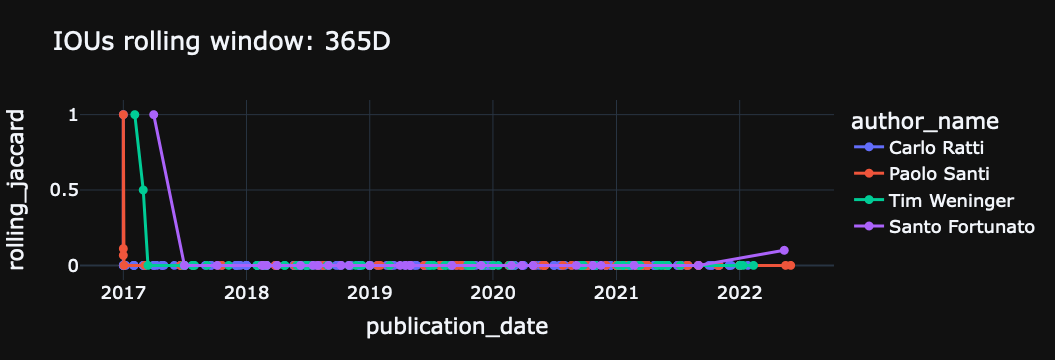

In [30]:
window = f'{combined_df.window_size.values[0]}' 
(
    combined_df
    .plot
    .line(y='rolling_jaccard', color='author_name', markers=True, 
          title=f'IOUs rolling window: {window}')
)